In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import os

# -----------------------------------
# 1. Set Paths and Data Generators
# -----------------------------------
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(val_dir,
                                                     target_size=IMG_SIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='binary')

test_generator = val_test_datagen.flow_from_directory(test_dir,
                                                      target_size=IMG_SIZE,
                                                      batch_size=1,  # Needed for per-image prediction
                                                      class_mode='binary',
                                                      shuffle=False)

Found 4434 images belonging to 2 classes.
Found 798 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:

# 2. Build VGG16 Model

def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze base
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg_model = build_vgg16()
vgg_model.fit(train_generator, validation_data=val_generator, epochs=5)

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.8624 - loss: 0.3274 - val_accuracy: 0.9110 - val_loss: 0.2297
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9340 - loss: 0.1728 - val_accuracy: 0.9386 - val_loss: 0.1576
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.9349 - loss: 0.1651 - val_accuracy: 0.9436 - val_loss: 0.1481
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.9373 - loss: 0.1535 - val_accuracy: 0.9586 - val_loss: 0.1166
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.9570 - loss: 0.1200 - val_accuracy: 0.9449 - val_loss: 0.1396


In [ ]:

# 3. Build Custom CNN Model

def build_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

custom_model = build_custom_cnn()
custom_model.fit(train_generator, validation_data=val_generator, epochs=5)


Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 66s 472ms/step - accuracy: 0.7650 - loss: 0.5351 - val_accuracy: 0.9248 - val_loss: 0.1775
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 581ms/step - accuracy: 0.8781 - loss: 0.2770 - val_accuracy: 0.9023 - val_loss: 0.2247
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 600ms/step - accuracy: 0.8989 - loss: 0.2414 - val_accuracy: 0.9461 - val_loss: 0.1499
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 85s 612ms/step - accuracy: 0.9095 - loss: 0.2231 - val_accuracy: 0.9449 - val_loss: 0.1307
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 571ms/step - accuracy: 0.9319 - loss: 0.1872 - val_accuracy: 0.9474 - val_loss: 0.1358


In [14]:
# 4. Make Predictions from Both Models
# -----------------------------------
vgg_preds = vgg_model.predict(test_generator)
custom_preds = custom_model.predict(test_generator)

624/624 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [15]:
# Average predictions for ensemble
ensemble_preds = (vgg_preds + custom_preds) / 2.0
ensemble_preds_binary = (ensemble_preds > 0.5).astype(int)

In [ ]:

# 5. Evaluate Ensemble Model

true_labels = test_generator.classes
print("\n📊 Classification Report for Ensemble Model:\n")
print(classification_report(true_labels, ensemble_preds_binary, target_names=['Normal', 'Pneumonia']))

ensemble_acc = accuracy_score(true_labels, ensemble_preds_binary)
print(f"\n✅ Ensemble Accuracy: {ensemble_acc * 100:.2f}%")


📊 Classification Report for Ensemble Model:

              precision    recall  f1-score   support

      Normal       0.97      0.78      0.87       234
   Pneumonia       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624


✅ Ensemble Accuracy: 91.03%


In [17]:
vgg_model.save("vgg16_model.keras")
custom_model.save("custom_cnn_model.keras")

2025-04-20 21:06:05.609 python[83127:1898595] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


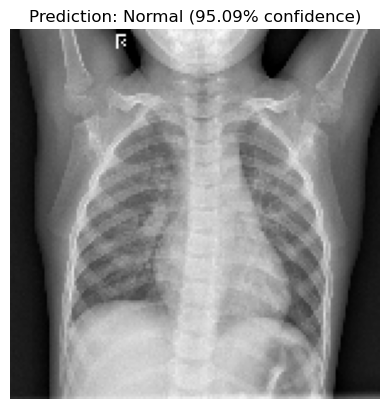


✅ The uploaded image is classified as: **Normal** with 95.09% confidence.


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog, Tk

# Load both models
vgg_model = tf.keras.models.load_model("vgg16_model.keras")
custom_model = tf.keras.models.load_model("custom_cnn_model.keras")

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def predict_ensemble(img_path):
    img_array, img_display = preprocess_image(img_path)

    # Get predictions from both models
    vgg_pred = vgg_model.predict(img_array)[0][0]
    custom_pred = custom_model.predict(img_array)[0][0]

    # Average the predictions
    ensemble_pred = (vgg_pred + custom_pred) / 2.0
    label = "Pneumonia" if ensemble_pred > 0.5 else "Normal"
    confidence = ensemble_pred if ensemble_pred > 0.5 else 1 - ensemble_pred

    # Show the result
    plt.imshow(img_display)
    plt.title(f"Prediction: {label} ({confidence*100:.2f}% confidence)")
    plt.axis('off')
    plt.show()

    print(f"\n✅ The uploaded image is classified as: **{label}** with {confidence*100:.2f}% confidence.")

def upload_and_classify():
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title="Select a Chest X-Ray Image")
    if file_path:
        predict_ensemble(file_path)
    else:
        print("No file selected.")

# 🔍 Run this to classify a new image
upload_and_classify()

In [17]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# ✅ 1. Load saved models
vgg_model = load_model("vgg16_model.keras")
custom_model = load_model("custom_cnn_model.keras")

# ✅ 2. Predict on test set
vgg_preds = vgg_model.predict(test_generator).ravel()
custom_preds = custom_model.predict(test_generator).ravel()
ensemble_preds = (vgg_preds + custom_preds) / 2.0


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


In [18]:
# ✅ 3. Convert probabilities to binary class labels
vgg_labels = (vgg_preds > 0.5).astype(int)
custom_labels = (custom_preds > 0.5).astype(int)
ensemble_labels = (ensemble_preds > 0.5).astype(int)

# ✅ 4. True labels
true_labels = test_generator.classes

In [19]:
# ✅ 5. Evaluation function
def evaluate_model(name, y_true, y_pred, y_prob):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_prob)
    }

In [20]:
# ✅ 6. Evaluate all three models
results = [
    evaluate_model("VGG16", true_labels, vgg_labels, vgg_preds),
    evaluate_model("Custom CNN", true_labels, custom_labels, custom_preds),
    evaluate_model("Ensemble", true_labels, ensemble_labels, ensemble_preds)
]

# ✅ 7. Show table
df = pd.DataFrame(results)
print("\n📊 Model Performance Comparison:\n")
print(df.round(4))


📊 Model Performance Comparison:

        Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0       VGG16    0.9199     0.9028  0.9769    0.9384   0.9673
1  Custom CNN    0.8413     0.8038  0.9872    0.8861   0.9592
2    Ensemble    0.9103     0.8830  0.9872    0.9322   0.9695


/var/folders/y3/y01h3w0s4sldyhwtlxfpx31c0000gn/T/ipykernel_53291/1694892268.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


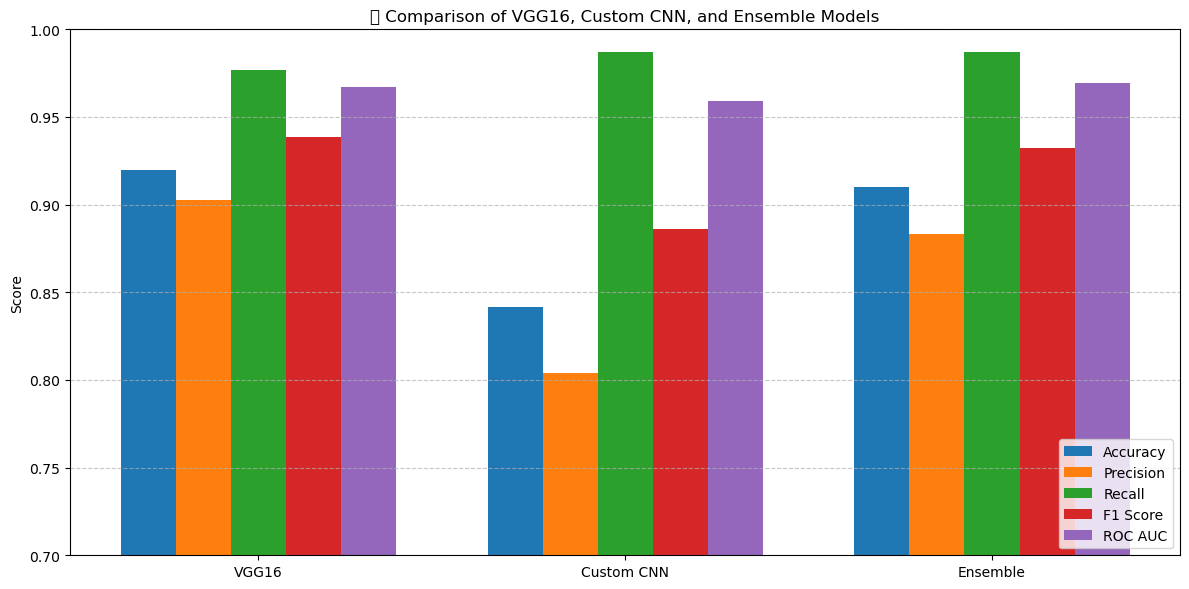

In [21]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 6))

# Define metrics and models
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
models = df["Model"]
x = np.arange(len(models))  # positions for bars

# Plot grouped bars
bar_width = 0.15

for i, metric in enumerate(metrics):
    plt.bar(x + i*bar_width, df[metric], width=bar_width, label=metric)

# Styling
plt.xticks(x + 2*bar_width, models)
plt.ylim(0.7, 1.0)
plt.ylabel("Score")
plt.title("📊 Comparison of VGG16, Custom CNN, and Ensemble Models")
plt.legend(loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

/var/folders/y3/y01h3w0s4sldyhwtlxfpx31c0000gn/T/ipykernel_53291/2796235307.py:28: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


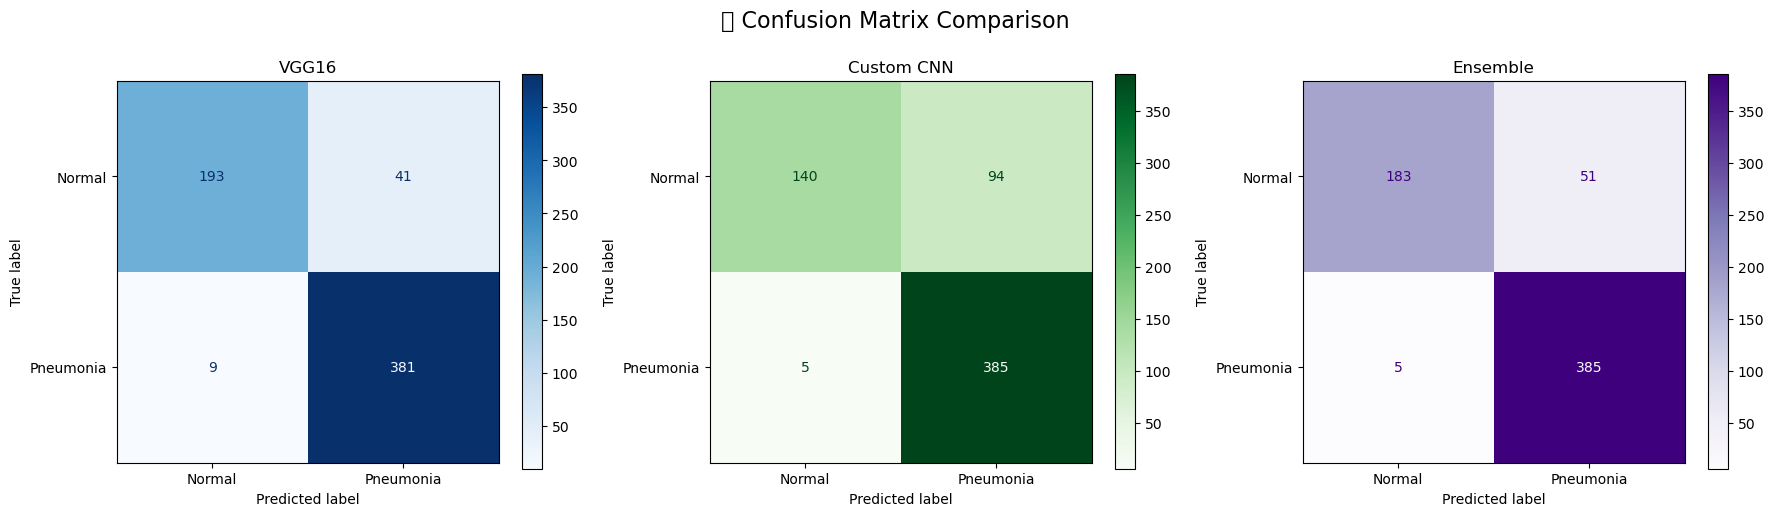

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute confusion matrices
cm_vgg = confusion_matrix(true_labels, vgg_labels)
cm_custom = confusion_matrix(true_labels, custom_labels)
cm_ensemble = confusion_matrix(true_labels, ensemble_labels)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot VGG16 Confusion Matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_vgg, display_labels=['Normal', 'Pneumonia'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("VGG16")

# Plot Custom CNN Confusion Matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=['Normal', 'Pneumonia'])
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title("Custom CNN")

# Plot Ensemble Confusion Matrix
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Normal', 'Pneumonia'])
disp3.plot(ax=axes[2], cmap='Purples', values_format='d')
axes[2].set_title("Ensemble")

# Adjust layout
plt.suptitle("🩺 Confusion Matrix Comparison", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

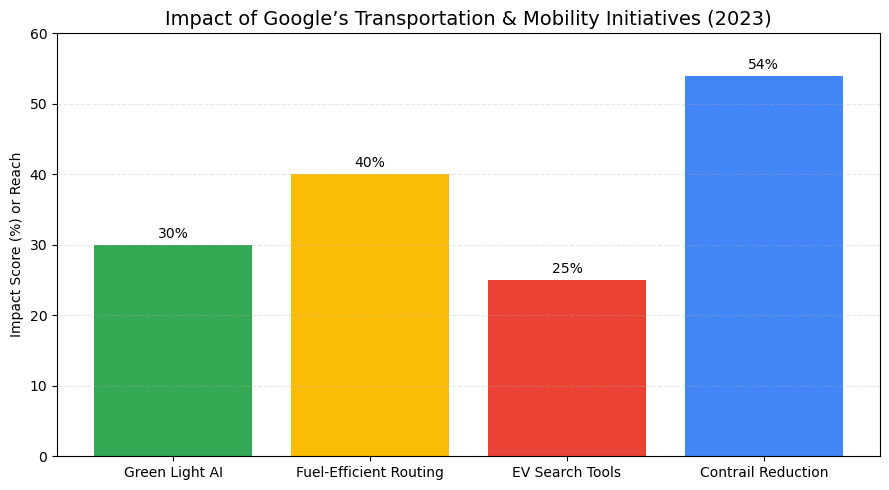

In [25]:
import matplotlib.pyplot as plt

# Initiatives and their respective scaled impact scores (illustrative)
initiatives = ['Green Light AI', 'Fuel-Efficient Routing', 'EV Search Tools', 'Contrail Reduction']
impact_scores = [30, 40, 25, 54]  # % improvement or no. of countries scaled

colors = ['#34a853', '#fbbc05', '#ea4335', '#4285f4']  # Google colors

plt.figure(figsize=(9, 5))
bars = plt.bar(initiatives, impact_scores, color=colors)

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval}%', ha='center', fontsize=10)

plt.title('Impact of Google’s Transportation & Mobility Initiatives (2023)', fontsize=14)
plt.ylabel('Impact Score (%) or Reach')
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()